# 📊 Análisis de videojuegos y pruebas de hipótesis para la tienda **ICE**.

In [1]:
# Importando todas las librerías necesarias
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
import math as mt
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, levene

#### Visualizamos el contenido del dataset.

In [2]:
# Cargamos el dataset
df_games = pd.read_csv("games.csv")

# Mostramos las 5 filas del dataset
df_games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Analizamos la información del dataset.

In [3]:
# Mostramos la iformación general del dataset
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Preparación y limpieza del dataset.

In [4]:
# Cambiamos los nombres de las columnas
New_name_columns = {"Name": "name",
                   "Platform": "platform",
                   "Year_of_Release": "year_of_release",
                   "Genre": "genre",
                   "NA_sales": "na_sales",
                   "EU_sales": "eu_sales",
                   "JP_sales": "jp_sales",
                   "Other_sales": "other_sales",
                   "Critic_Score": "critic_score",
                   "User_Score": "user_score",
                   "Rating": "rating"}

df_games.rename(columns= New_name_columns, inplace=True)

print("Detección de filas duplicadas:",df_games.duplicated().sum())

print("Detección de valores ausentes:")

df_games.isna().sum()

Detección de filas duplicadas: 0
Detección de valores ausentes:


name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [5]:
# Convertimos el tipo de dato de year_of_release a su tipo correcto
df_games["year_of_release"] = df_games["year_of_release"].astype("Int64")

# Rellenamos los valores ausentes con "Unknown" de la columna name
df_games["name"] = df_games['name'].fillna("Unknown")

# Rellenamos los valores ausentes con la mediana de la columna critic_score
critic_score_median = df_games["critic_score"].median()
df_games['critic_score'] = df_games['critic_score'].fillna(critic_score_median)
df_games['critic_score'] = df_games['critic_score'].astype("int")

# Cambiamos por Nan cualquier valor que no sea numérico en la columna user_score
df_games['user_score'] = pd.to_numeric(df_games['user_score'],
                                      errors="coerce")

# Rellenamos los valores ausentes con la mediana de la columna user_score
user_score_median = df_games["user_score"].median()
df_games['user_score'] = df_games['user_score'].fillna(user_score_median)

# Rellenamos los valores ausentes con "Unknown" de la columna genre
df_games['genre'] = df_games['genre'].fillna("Unknown")

**Limpieza y preparación del dataset.**

- **Nombres de las columnas:** Se aplicó la convención snake_case a los nombres de las columnas para una manipulación más sencilla y consistente.
- **Valores ausentes y tipos de datos:** Se inspeccionaron los datos para detectar valores ausentes y se tomaron decisiones específicas para cada columna, justificando el método elegido:

    - **year_of_release:** Los valores ausentes se mantuvieron como nulos. La columna fue convertida a un tipo de dato entero (Int64) que puede manejar valores nulos para reflejar con precisión la naturaleza discreta de los años de lanzamiento sin introducir sesgo.

    - **name y genre:** Los valores ausentes en estas columnas categóricas se rellenaron con la etiqueta "Unknown". Esto permite conservar las filas para el análisis general sin hacer suposiciones sobre los datos faltantes.

    - **critic_score:** Los valores ausentes fueron remplazados con la mediana de esta columna y posteriornmente convertimos el tipo de dato de la columna a tipo entero.

    - **user_score:** Los valores no numéricos ("tbd") fueron reemplazados por nulos. Posteriormente, los valores ausentes en esta columna se rellenaron con la mediana de esta columna, en donde mantuvimos su tipo de dato flotante.

    - **raiting:** Los valores ausentes se mantuvieron como nulos. Al haber una gran cantidad de valores ausentes, se optó por no suponer que todos eran desconocidos para no introducir un sesgo innecesarion en el análisis. Está columna se excluira de cuaquier análisis que dependa directamente de la clasificación.

#### ¿Por qué crees que los valores están ausentes?

**Al revisar el dataset, se observa que los datos de algunos juegos fueron recolectados antes de recibir suficientes reseñas por parte de la crítica y de los usuarios, o antes de ser clasificados por la ESRB. Esto explica por qué en las columnas critic_score, user_score y rating se concentra la mayor cantidad de valores ausentes.**

#### Calculo de ventas globales para cada videojuego.

In [6]:
# Creamos la columna total_sales para las ventas globales de cada videojuego lanzado
df_games["total_sales"] = df_games['eu_sales'] + df_games['jp_sales'] + df_games['na_sales'] + df_games['other_sales']

df_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,71,7.5,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,71,7.5,NaN,31.38


## Análisis exploratorio (**EDA**).

### Cantidad de videojuegos lanzados en cada año. 

In [7]:
# Agrupamos por año y contamos la cantidad de videojuegos lanzados
games_releaded_per_year = df_games.groupby("year_of_release")["name"].count()

games_releaded_per_year

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      62
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

### ¿Son significativos los datos de cada período?

**Al revisar los lanzamientos de videojuegos por año, observamos que los datos muestran una tendencia significativa: al inicio del dataset (1980), la cantidad de videojuegos lanzados era muy reducida, mientras que hacia los últimos años (2014–2016) la cifra crece considerablemente. Esto puede deberse a que, en sus inicios, la industria de los videojuegos apenas estaba surgiendo, mientras que en los años recientes ya se encontraba consolidada y en expansión.**

### Pensar en un mejor titulo.

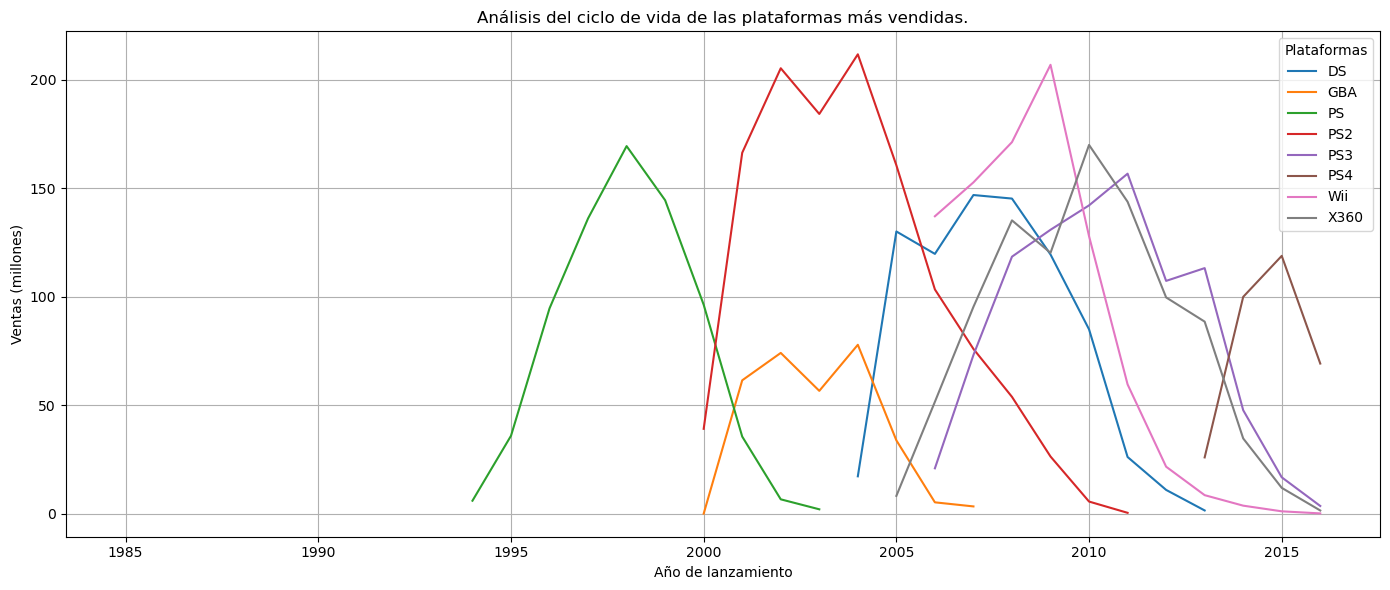

In [8]:
# Creamos una tabla dinámica para ver la distribución de ventas por año y plataforma
total_sales_by_platforms_for_year = df_games.pivot_table(index=["year_of_release", "platform"],
                                  values="total_sales",
                                  aggfunc="sum").reset_index()

# Agrupamos por plataforma y sumamos las ventas totales para cada una
total_sales_by_platforms = total_sales_by_platforms_for_year.groupby('platform')['total_sales'].sum().reset_index()

# Filtramos las plataformas con ventas totales mayores a 300 millones
platforms_highest_global_sales = total_sales_by_platforms[total_sales_by_platforms["total_sales"] > 300]["platform"].tolist()

# Filtramos la tabla dinámica para quedarnos solo con las plataformas más exitosas
platform_filtered = total_sales_by_platforms_for_year[total_sales_by_platforms_for_year['platform'].isin(platforms_highest_global_sales)]

# Creamos la tabla dinámica para las plataformas filtradas
final_total_sales_by_platform_filtered = platform_filtered.pivot_table(index="year_of_release", columns="platform", values="total_sales")

# Graficamos la distribución de ventas por año de las consolas más exitosas
final_total_sales_by_platform_filtered.plot(kind="line",
                                            figsize=(14,6),
                                            title="Análisis del ciclo de vida de las plataformas más vendidas.")

# Personalizamos el gráfico
plt.ylabel("Ventas (millones)")
plt.xlabel("Año de lanzamiento")
plt.legend(title="Plataformas")
plt.grid(True)
plt.tight_layout()

# Mostramos el gráfico
plt.show()

**Al analizar el gráfico, observamos el comportamiento de las plataformas con mayores ventas a lo largo del tiempo, además de poder ver el inicio y final de cada una. También podemos observar su mejor momento, siendo el máximo representante la plataforma PS2 (2000-2011).**

### Busca un buen titulo.

In [ ]:
# Análisis del ciclo de vida de las plataformas más vendidas
platform_year_range = df_games.groupby("platform")["year_of_release"].agg(["min", "max"]).reset_index()
platform_year_range.columns = ["platform", "start_year", "final_year"]

# Creamos la columna tiempo_de_vida 
platform_year_range["life_time"] = platform_year_range["final_year"] - platform_year_range["start_year"]

# Calculamos el total de ventas por plataforma en un Series
platforms_total_sales = df_games.groupby("platform")["total_sales"].sum()

# Unimos la tabla del ciclo de vida con el total de ventas por plataforma 
platform_year_range = platform_year_range.merge(platforms_total_sales, on="platform")

platform_year_range.sort_values(by="total_sales", ascending=False)

,platform,start_year,final_year,life_time,total_sales
16,PS2,2000,2011,11,1255.77
28,X360,2005,2016,11,971.42
17,PS3,2006,2016,10,939.65
26,Wii,2006,2016,10,907.51
4,DS,1985,2013,28,806.12
15,PS,1994,2003,9,730.86
6,GBA,2000,2007,7,317.85
18,PS4,2013,2016,3,314.14
19,PSP,2004,2015,11,294.05
13,PC,1985,2016,31,259.52


**Al analizar la tabla, observamos el ciclo de vida de las plataformas y podemos identificar a las plataformas que solian ser populares. Un claro ejemplo de ello es la PS2, que, basandonos en los datos de la tabla, tuvo un ciclo de vida de 11 años y un impresionante total de ventas 1255 millones. Al comparar su desempeño con otras plataformas, como la Nintendo DS (con una duración de 28 años y 806 millones en ventas), se evidencia que las consolas más populares, a pesar de su longevidad, eventualmente son reemplazadas por nuevos lanzamientos.**

### ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?

In [38]:
# Creamos una tabla con los datos ordenados por el año de lanzamiento
platform_year_range_sorted = platform_year_range.sort_values(by="start_year")

# Creamos la columna time_between_launches
platform_year_range_sorted["time_between_launches"] = platform_year_range_sorted["start_year"].diff()


# Creamos una tabla con los datos ordenados por los años de finalización
platform_year_range_sorted_by_end = platform_year_range_sorted.sort_values(by="final_year")

# Creamos la columna time_between_disappearances
platform_year_range_sorted_by_end["time_between_disappearances"] = platform_year_range_sorted_by_end["final_year"].diff()

# Calculamos la mediana para cada columna y las mostramos

print("Tiempo que tarda en aparecer una nueva plataforma:", platform_year_range_sorted["time_between_launches"].median())
print("Tiempo que tarda en desaparecer una plataforma:", platform_year_range_sorted_by_end["time_between_disappearances"].median())

Tiempo que tarda en aparecer una nueva plataforma: 1.0
Tiempo que tarda en desaparecer una plataforma: 0.0


**Basado en nuestro análisis, el tiempo que tardan en aparecer las nuevas plataformas es de 1 año. Sin embargo, la información sobre el tiempo que tardan en desaparecer es menos clara. La mediana de la diferencia entre los años de finalización es de 0 años, lo que sugiere que muchos de los últimos lanzamientos de juegos se concentraron en el último año de los datos. Esta limitación del conjunto de datos hace que sea difícil determinar un tiempo de 'desaparición' preciso para las plataformas más antiguas.**

# 2.3 Creación de un modelo en base a los datos de años anteriores para 2017

In [39]:
filtered_games = df_games[(df_games['year_of_release'] >= 2014) & (df_games['year_of_release'] <= 2016)]

top_genre = filtered_games.groupby("genre")["genre"].count().reset_index(name="count_genre")

top_sales_genre = filtered_games.groupby("genre")["total_sales"].sum().reset_index()

merge_genre = top_genre.merge(top_sales_genre, on="genre")

merge_genre = merge_genre.rename(columns={"genre": "Género",
                                         "count_genre": "Cantidad_de_juegos",
                                         "total_sales": "Ventas_totales"})

merge_genre.sort_values(by="Ventas_totales", ascending=False).reset_index(drop=True)

,Género,Cantidad_de_juegos,Ventas_totales
0,Action,619,199.36
1,Shooter,128,170.94
2,Sports,161,109.48
3,Role-Playing,221,101.44
4,Misc,113,37.55
5,Fighting,60,28.22
6,Racing,69,27.52
7,Platform,38,18.09
8,Adventure,185,17.55
9,Simulation,44,13.13


**Gracias a la tabla que hicimos podemos permitirnos construir un modelo para 2017.**

**Para empezar lo primero fue escoger una serie de años para construir nuestro modelo y tomamos los años de 2014 a 2016, para despues contar los generos que mas veces salieron en esos 3 años y despues calculamos el total de ventas para cada genero para poder ver que género genero mas ventas en estos 3 años.**

**Y despues podemos decir que para nuestro modelo de 2017, hemos visto que los géneros que generaron mas de 100 millones de los dolares en ventas se han logrado mantener en lo mas alto a lo largo de 3 años, por lo que podemos decir que esos 4 géneros se mantendran en 2017 y talvez algunos bajen y otros suban, pero se mantendran dentro los primeros lugares.**

**Y por ultimo podemos decir que los géneros que generaron menos de 100 millones en ventas, son muy variables ya que no podemos decir a ciencia cierta que géneros se mantendran en ese rango, por lo que aqui podemos decir que son bastante variables.**

# 2.4 ¿Qué plataformas son lideres en ventas? Y ¿Cuáles crecen y cuáles se reducen?

In [12]:
filtered_platforms = df_games[(df_games['year_of_release'] >= 2006) & (df_games['year_of_release'] <= 2011)]

grouop_platforms = filtered_platforms.groupby("platform")["total_sales"].sum().reset_index()

grouop_platforms.columns = ["Plataformas", "Ventas_Totales"]

list_platforms = grouop_platforms[grouop_platforms['Ventas_Totales'] > 100]["Plataformas"].tolist()

platforms = filtered_platforms[filtered_platforms['platform'].isin(list_platforms)]

pivot_platforms = platforms.pivot_table(index="year_of_release",
                                       columns="platform",
                                       values="total_sales",
                                       aggfunc="sum")

diff_platforms = pivot_platforms.diff()

pivot_platforms

platform,DS,PC,PS2,PS3,PSP,Wii,X360
year_of_release,,,,,,,
2006,119.81,2.85,103.42,20.96,55.32,137.15,51.62
2007,146.94,9.28,75.99,73.19,46.93,152.77,95.41
2008,145.31,12.42,53.90,118.52,34.55,171.32,135.26
2009,119.54,16.91,26.40,130.93,37.78,206.97,120.29
2010,85.02,24.28,5.64,142.17,35.04,127.95,170.03
2011,26.18,35.03,0.45,156.78,17.82,59.65,143.84


**Para hacer este analisis sobre las plataformas lideres en venta, escogi un rango de años donde los juegos lanzados eran mas de 1000 y empieza desde el año 2006 y termina en el año 2011.**

**Para empezar primero respondamos la siguiente pregunta ¿Qué plataformas son líderes en ventas? Las plataformas que son líderes en ventas en ese rango de años son: DS, PS3, Wii, Xbox 360 y PC (esta ultima es la más potencialmente rentable a un futuro) y esas plataformas en ese rango de años fueron potencialmente rentables.**

**Y para responder la segunda pregunta ¿Cuáles crecen y cuáles se reducen? para responder esta pregunta usamos el metodo diff en nuestra tabla anterior para comprobar si las ventas de dichas plataformas estaban creciendo o decreciendo, y como podemos ver a pesar de que las plataformas que escogimos fueron potencialmente rentables, ya para el rango de años que prevamiento habia escogido ya estaban a la baja, pero gracias al metodo diif pudimos identificar mejor las plataformas que crecieron y decrecieron.**

# 2.5 Diagrama de caja para las ventas globales de todos los juegos

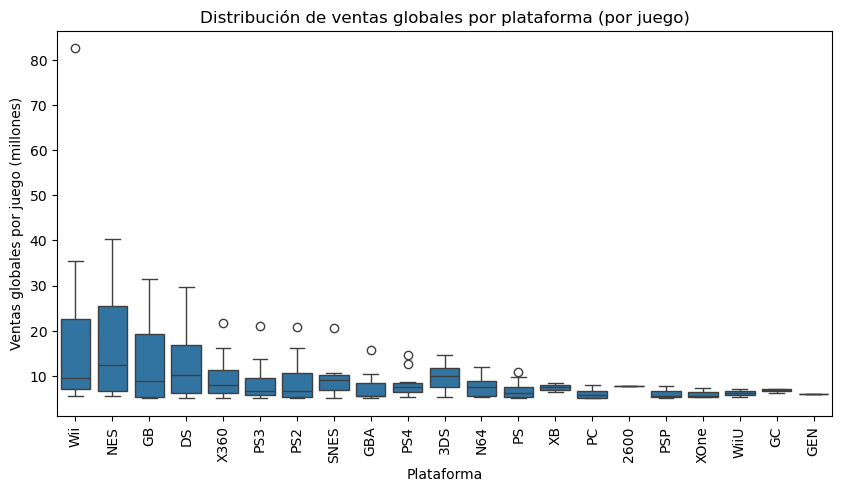

In [13]:
filtered_games = df_games[df_games['total_sales'] >= 5]


plt.figure(figsize=[10,5])
sns.boxplot(data=filtered_games,
           x="platform",
           y="total_sales")
plt.xticks(rotation=90)
plt.title("Distribución de ventas globales por plataforma (por juego)")
plt.xlabel("Plataforma")
plt.ylabel("Ventas globales por juego (millones)")
plt.show()

**Para empezar lo primero que hicimos fue filtrar juegos que tengan ventas totales o globales mayores a 5 millones ¿Por qué hicimos esto? lo hicimos para poder visualizar el diagrama de caja de mejor manera, ya que si lo imprimiamos con todas las plataformas el grafico se llenaba de demasiados puntos(valores atipicos) y no nos dejaba leer de manera visual las ventas globales para de todos los juegos y es por eso el que tome esta decisión.**

**Y respondiendo la pregunta ¿Son significativas las diferencias en las ventas? por lo que vemos en el diagrma de caja, si es demasiada la diferencia de ventas entre plataformas, pero tenemos que entender que algunas plataformas estaban en su mejor momento y otras apenas estaban saliendo al mercado, ademas de que usamos el DataFrame original sin alguna selección de rango de años .**

# 2.6 Promedio de ventas en varias plataformas

In [14]:
mean_sales = df_games.groupby("platform")["total_sales"].mean().reset_index(name="mean_sales")


mean_sales[mean_sales['mean_sales'] >= 0.50].sort_values(by="mean_sales", ascending=False).reset_index(drop=True)

,platform,mean_sales
0,GB,2.606735
1,NES,2.561735
2,GEN,1.061034
3,SNES,0.836987
4,PS4,0.801378
5,X360,0.769746
6,2600,0.729173
7,PS3,0.705973
8,Wii,0.687508
9,N64,0.685517


**Para empezar lo primero que hice fue filtrar por el promedio de ventas fuera mayor a 0.50 para asi poder leer mejor los datos sin tantas plataformas irrelevantes.**

**Y por lo que vemos en la tabla, el promedio de muchas plataformas es muy pequeño a pesar de la cantidad de venta globales que llegaron a hacer, tal caso es el de la PS2 que llego a poco más de 1200 millones en ventas globales, por lo que creo que gracias a lo visto en la tabla podemos decir que a pesar de que las plataformas hayan tenido un total de ventas globales muy altos, sus promedios dejan mucho que decir, ya que a pesar de ser tan vendida lo mas seguro es que esas consolas tuvieron demasiados juegos lanzados en esa mismas consolas por lo que su promedio se vio afectado.**

# 2.7 Reseñas de usuarios y profesionales y la correlacion entre reseñas y ventas

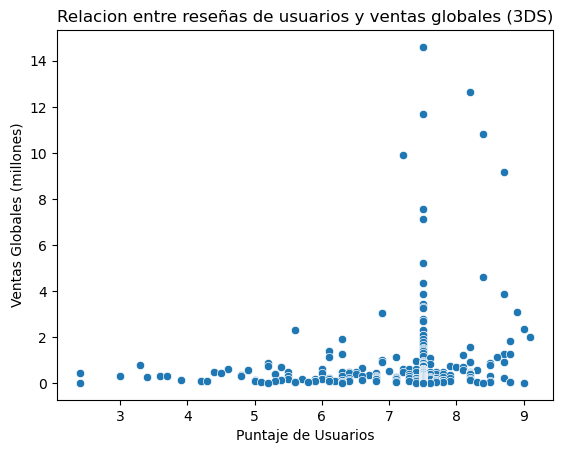

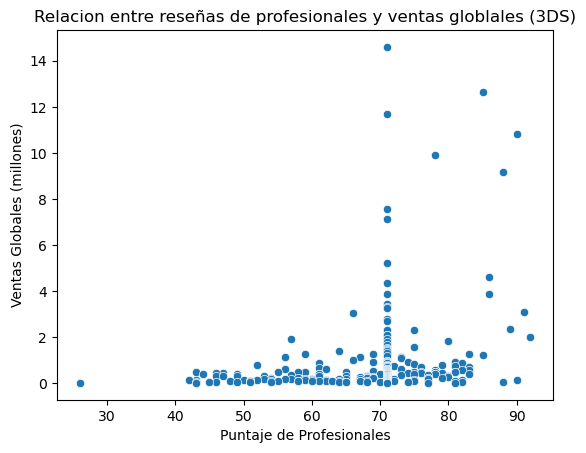

In [15]:
filtered_3DS = df_games[df_games['platform'] == "3DS"]

sns.scatterplot(data=filtered_3DS,
               x="user_score",
               y="total_sales")
plt.title("Relacion entre reseñas de usuarios y ventas globales (3DS)")
plt.xlabel("Puntaje de Usuarios")
plt.ylabel("Ventas Globales (millones)")
plt.show()

sns.scatterplot(data=filtered_3DS,
               x="critic_score",
               y="total_sales")
plt.title("Relacion entre reseñas de profesionales y ventas globlales (3DS)")
plt.xlabel("Puntaje de Profesionales")
plt.ylabel("Ventas Globales (millones)")
plt.show()

In [16]:
covarianza_user_and_sales_3DS = np.cov(filtered_3DS['user_score'], filtered_3DS["total_sales"])[0,1]                     
covarianza_critic_and_sales_3DS = np.cov(filtered_3DS['critic_score'], filtered_3DS["total_sales"])[0,1]

std_user = np.std(filtered_3DS['user_score'])
std_critic = np.std(filtered_3DS['critic_score'])
std_total = np.std(filtered_3DS['total_sales'])

correlacion_user_and_sales = covarianza_user_and_sales_3DS / (std_user * std_total)

correlacion_critic_and_sales = covarianza_critic_and_sales_3DS / (std_critic * std_total)

print("Correlación entre Usuarios y Ventas Globales:", "\n",correlacion_user_and_sales, "\n")
print("Correlación entre Critica y Ventas Globales:", "\n",correlacion_critic_and_sales)

Correlación entre Usuarios y Ventas Globales: 
 0.10023487800185256 

Correlación entre Critica y Ventas Globales: 
 0.1984836246944155


**Para empezar, en el primer grafico de "user_score entre total_sales" vemos muchos puntos dispersos, pero entre el eje x(5) y eje x(8.5) vemos mas datos acumulados entre esa zona, ademas de que el eje x(7.5) vemos que los datos empiezan a hacer una tipo de linea vertical en donde vemos en que solo un juego llego a los 14 millones de ventas globales.**

**En el segundo grafico podemos cierto parecido en la linea que se formaba por la acumulacion de los datos y lo mismo  que paso en el anterior grafico aqui se repite en el que un solo juego llego a los 14 millones de ventas, pero la diferencia de este grafico al otro es que sus datos estan menos dispersos y existe una mayor acumulacion entre el eje x(40) y el eje x(80).**

**Y despues vemos la correlacion entre las reseñas y ventas, primero empezamos por la correlacion entre las reseñas de los usarios y ventas y por lo que vimos es que su relacion es muy baja por lo que las reseñas de los usuarios no afectan a las ventas globales.**

**Y por ultimo vemos la correlacion entre las reseñas por profesionales y ventas y vemos que en este caso si existe una mayor relacion comparada a la correlacion anterior, pero aun asi la relacion sigue siendo baja, por lo que en este caso las reseñas por profesionales si afectan un poco a las ventas.**

# 2.8 Comparación de ventas en los mismos juegos en otras plataformas

In [17]:
filtered_PS2 = df_games[df_games['platform'] == "PS2"]
filtered_X360 = df_games[df_games['platform'] == "X360"]
filtered_Wii = df_games[df_games['platform'] == "Wii"]

def correlacion_user(DF):
    covarianza = np.cov(DF['user_score'], DF["total_sales"])[0,1]

    std_user = np.std(DF['user_score'])
    std_total = np.std(DF['total_sales'])

    correlacion = covarianza / (std_user * std_total)
    
    return correlacion
    
def correlacion_critic(DF):
    covarianza = np.cov(DF['critic_score'], DF["total_sales"])[0,1]

    std_critic = np.std(DF["critic_score"])
    std_total = np.std(DF["total_sales"])

    correlacion = covarianza / (std_critic * std_total)

    return correlacion

print("Correlación entre Usuarios y Ventas Globales (PS2):", correlacion_user(filtered_PS2))
print("Correlación entre Critica y Ventas Globales (PS2):", correlacion_critic(filtered_PS2),"\n")
print("Correlación entre Usuarios y Ventas Globales (X360):", correlacion_user(filtered_X360))
print("Correlación entre Critica y Ventas Globales (X360):", correlacion_critic(filtered_X360),"\n")
print("Correlación entre Usuarios y Ventas Globales (Wii):", correlacion_user(filtered_Wii))
print("Correlacion entre Critica y Ventas Globales (Wii):", correlacion_critic(filtered_Wii))

Correlación entre Usuarios y Ventas Globales (PS2): 0.1749375358721195
Correlación entre Critica y Ventas Globales (PS2): 0.34563651531765904 

Correlación entre Usuarios y Ventas Globales (X360): 0.05890818625055785
Correlación entre Critica y Ventas Globales (X360): 0.36118024655055564 

Correlación entre Usuarios y Ventas Globales (Wii): 0.05451422807079059
Correlacion entre Critica y Ventas Globales (Wii): 0.10657539055608442


**Gracias a lo que vemos en la correlacion, que lo mismo pasa aqui, pero con ligeras o grandes diferencias, asi que la conclusion ahora es que algunas plataformas les pueden afectar mas las reseñas de usuarios, pero las reseñas de las criticas son las que tienen mas posibilidad de afectar las ventas, por lo que solo una pequeña parte de las ventas globales es afectada por las reseñas.**

# 2.9 Distribución general de los juegos por género

In [18]:
group_genre = df_games.groupby("genre")["genre"].count().reset_index(name="Cantidad_de_juegos")

group_sales = df_games.groupby("genre")["total_sales"].sum().reset_index()

merge = group_genre.merge(group_sales, on="genre")

merge.columns = ["Genero", "Cantidad_de_juegos", "Ventas_totales"] 

merge["Promedio_ventas"] = merge['Ventas_totales'] / merge['Cantidad_de_juegos']

merge

,Genero,Cantidad_de_juegos,Ventas_totales,Promedio_ventas
0,Action,3369,1744.17,0.517711
1,Adventure,1303,237.59,0.182341
2,Fighting,849,447.53,0.527126
3,Misc,1750,802.51,0.458577
4,Platform,888,827.77,0.932173
5,Puzzle,580,242.57,0.418224
6,Racing,1249,728.67,0.583403
7,Role-Playing,1498,934.56,0.623872
8,Shooter,1323,1052.45,0.795503
9,Simulation,873,389.97,0.446701


**Para empezar, lo primero que hicimos fue dar un vistazo general a la distribución de los juegos por género, donde vemos que el género con mas titulos lanzados es "Action" y el segundo "Sports".**

**¿Qué se puede decir de los géneros más rentables? Podemos decir que los géneros mas rentables son los que mas titulos lanzados tienen, pero tambien géneros con una cantidad menor de titulos obteniendo una buena rentabilidad, por lo que aqui parece ser que depende de la popularidad del género.**

**¿Puedes generalizar acerca de los géneros con ventas altas y bajas? Si vemos en la tabla podemos observar la columna "Promedio_ventas" donde podemos ver que algunos géneros tienen muchos titulos lanzados pero con un promedio bajo a comparacion de géneros con menos titulos lanzados donde tienen un promedio más alto, por lo que aqui se puede decir que importa demasiado la popularidad del género.**

# 3.- Top 5 principales plataformas por región

In [19]:
region_sales = df_games.groupby("platform")[["na_sales", "eu_sales", "jp_sales"]].sum()

top_5_NA = region_sales["na_sales"].sort_values(ascending=False).head()
top_5_EU = region_sales["eu_sales"].sort_values(ascending=False).head()
top_5_JP = region_sales["jp_sales"].sort_values(ascending=False).head()

print("Top 5 plataformas de la región NA", "\n", top_5_NA,"\n")
print("Top 5 plataformas de la región EU", "\n", top_5_EU,"\n")
print("Top 5 plataformasde la region JP", "\n", top_5_JP)

Top 5 plataformas de la región NA 
 platform
X360    602.47
PS2     583.84
Wii     496.90
PS3     393.49
DS      382.40
Name: na_sales, dtype: float64 

Top 5 plataformas de la región EU 
 platform
PS2     339.29
PS3     330.29
X360    270.76
Wii     262.21
PS      213.61
Name: eu_sales, dtype: float64 

Top 5 plataformasde la region JP 
 platform
DS      175.57
PS      139.82
PS2     139.20
SNES    116.55
3DS     100.67
Name: jp_sales, dtype: float64


**Para empezar vemos que en las 3 regiones las 5 principales plataformas son diferentes entre cada región, en donde la plataforma que mas ventas genera en la región NA es la Xbox360 y en las demas regiones no es asi, ya que en la región EU es la tercera con  mas ventas y en la región JP np aparece en el top 5, por lo que en este caso las ventas de una plataforma de una región a otra son muy diferentes.**

# 3.1 Cuotas de mercado de las principales plataformas por región

In [20]:
cuotas = pd.concat([top_5_NA, top_5_EU, top_5_JP], axis=1)

cuotas.columns= ["NA", "EU", "JP"]

cuotas_porcent = cuotas.div(cuotas.sum()) * 100

print("Cuotas de mercado de las principales plataformas por región (%):", "\n", cuotas_porcent)

Cuotas de mercado de las principales plataformas por región (%): 
                  NA         EU         JP
platform                                 
X360      24.499614  19.119309        NaN
PS2       23.742019  23.958451  20.720144
Wii       20.206580  18.515563        NaN
PS3       16.001383  23.322930        NaN
DS        15.550405        NaN  26.133877
PS              NaN  15.083748  20.812432
SNES            NaN        NaN  17.348655
3DS             NaN        NaN  14.984892


**Para empezar, hicimos que esta tabla se mostrara en porcentajes para poder tener una mejor comprension sobre que tanto aporta una plataforma en las distintas regiones.**

**Y lo que vemos es que algunas plataformas no me aparacen en algunas regiones, esto se debera a que algunas plataformas no fueron muy vendidads en algunas regiones, por lo que podemos decir que las cuotas de mercado de cada plataforma son muy diferentes entre las 3 regiones, y la plataforma que mas ventas logro entre todos los mercados fue la PS2.**

# 3.2 Principales géneros entre las regiones (NA, EU, JP)

In [21]:
genre = df_games.groupby("genre")[["na_sales", "eu_sales", "jp_sales"]].sum()

top_5_NA = genre['na_sales'].sort_values(ascending=False).head()
top_5_EU = genre['eu_sales'].sort_values(ascending=False).head()
top_5_JP = genre['jp_sales'].sort_values(ascending=False).head()

concat_genre = pd.concat([top_5_NA, top_5_EU, top_5_JP], axis=1)

concat_genre

,na_sales,eu_sales,jp_sales
genre,,,
Action,879.01,519.13,161.43
Sports,684.43,376.79,135.54
Shooter,592.24,317.34,NaN
Platform,445.50,NaN,130.83
Misc,407.27,212.74,108.11
Racing,NaN,236.51,NaN
Role-Playing,NaN,NaN,355.41


**Gracias a la tabla que hicimos, podemos ver que los cinco géneros principales.**

**Y podemos ver que el género Action es género con mas ventas en total y por ende es el género mas popular, seguido del género Action tenemos el género Sports que tambien una cantidad asombrosa de ventas y popularidad en todas las regiones.**

**Por lo podemos decir que tenemos muchisimas diferencias de géneros entre regiones y que en la región JP el género que mas ventas hizo fue el Role-Playing.**

# 3.3 ¿Las clasificaciones de ESRB afectan a las ventas en regiones individuales?

In [22]:
rating = pd.get_dummies(df_games["rating"])

concat = pd.concat([rating, df_games[["na_sales", "eu_sales", "jp_sales"]]], axis=1)

correlacion = concat.corr()

correlacion[["na_sales", "eu_sales", "jp_sales"]].loc[rating.columns]

,na_sales,eu_sales,jp_sales
AO,0.009475,0.007145,-0.001944
E,0.041764,0.036656,-0.050704
E10+,-0.005453,-0.007445,-0.048645
EC,-0.001940,-0.005709,-0.005499
K-A,0.009716,-0.001466,0.017745
M,0.085072,0.105022,-0.037975
RP,-0.004337,-0.003152,-0.003367
T,-0.003873,-0.000776,-0.039790


**Como podemos ver en nuestra tabla,la mayoria de clasificaciones tienen una relacion ligeramente negativa, por ejemplo:
la clasificación M que en este caso tiene una relacion positiva pero muy baja, por lo que se puede decir que no afectan a las ventas en distintas regiones y tambien tenemos a la clasificacion UNK que en este caso tiene una relacion negativa pero muy baja, por lo queb sucede el mismo caso que el anterior ya que no afectan a as ventas en distintas regiones.**

**Por lo que podemos decir que las clasificaciones no afectan a las ventas en distintas regiones, ya que a pesar de tener una relacion positiva o negativa son muy bajas que se les puede considerar casi nula.**

# 3.4 Prueba de hipótesis para las calificaciones promedio de los usuarios de las platformas Xbox One y PC

*Hipótesis nula: las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.*

*Hipótesis alternativa: las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.*

**Escogí la hipótesis nula como que las calificaciones son iguales, y la alternativa como que son diferentes, porque es más fácil detectar una diferencia que probar igualdad. Así, si hay una diferencia real entre las calificaciones promedio de usuarios entre Xbox One y PC, es más probable que el análisis lo detecte. Esto nos permitiría sacar conclusiones más útiles sobre si una plataforma recibe mejores valoraciones que otra.**

**Y estableci el margen de umbral alfa como 0.05 porque este margen representa un equilibrio ya que este margen nos permite tener la confianza en los resultados sin ser demasiados estrictos ni demasiados laxos.**

In [23]:
XOne_score = df_games[df_games["platform"] == "XOne"]["user_score"]
PC_score = df_games[df_games['platform'] == "PC"]["user_score"]

alpha = 0.05

levene_stat, levene_p = levene(XOne_score, PC_score)
print("Prueba de Levene - ValorP:", levene_p)

if levene_p < alpha:
    print("Rechazamos la hipótesis nula de Levene: las varianzas NO son iguales.")
    equal_var = False
else:
    print("No podemos rechazar la hipótesis nula de Levene: las varianzas son iguales.")
    equal_var = True

results = ttest_ind(XOne_score, PC_score, equal_var=equal_var)
print("Prueba T - Valor P:", results.pvalue)    

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula (hay evidencia de diferencia en las medias).")
else:
    print("No podemos rechazar la hipótesis nula (no hay evidencia suficiente).")

Prueba de Levene - ValorP: 0.9929649852182456
No podemos rechazar la hipótesis nula de Levene: las varianzas son iguales.
Prueba T - Valor P: 0.00010123955107193582
Rechazamos la hipótesis nula (hay evidencia de diferencia en las medias).


**Gracias a la prueba de hipótesis, concluimos que las calificaciones de usuarios entre las plataformas Xbox One y PC son muy diferentes y tal vez esto se deba a que la PC apenas estaba en pleno crecimiento.**

# 3.5 Prueba de hipótesis para las calificaciones promedio de los géneros Acción y Deportes

*Hipótesis nula: las calificaciones promedio de los usuarios para los géneros de Acción y Deportes 
son iguales.*

*Hipótesis alternativa: las calificaciones promedio de los usuarios para los géneros de Acción y 
Deportes son diferentes.*

**¿Por qué escogi que la hipótesis nula sea que las calificaciones son iguales y para la alternativa sean diferentes? lo escogi así, porque seguimos el mismo principio, ya que es más facil detectar las diferencias a que probar igualdad y esto nos llevara a conseguir conclusiones más utiles sobre las calificaciones promedio de los usuarios.**

**Estableci el margen de umbral alfa como 0.05, ya que este margen al ser tan equilibrado nos permite tener la confianza de los resultados sin ser demasiados estrictos ni demasiados laxos.**

In [24]:
Action_score = df_games[df_games['genre'] == "Action"]["user_score"]
Sports_score = df_games[df_games['genre'] == "Sports"]["user_score"]

alpha = 0.05

levene_stat, levene_p = levene(Action_score, Sports_score)
print("Prueba de Levene - ValorP:", levene_p)

if levene_p < alpha:
    print("Rechazamos la hipótesis nula de Levene: las varianzas NO son iguales.")
    equal_var = False
else:
    print("No podemos rechazar la hipótesis nula de Levene: las varianzas son iguales.")
    equal_var = True

results = ttest_ind(Action_score, Sports_score, equal_var=equal_var)
print("Prueba T - Valor P:", results.pvalue)    

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula (hay evidencia de diferencia en las medias).")
else:
    print("No podemos rechazar la hipótesis nula (no hay evidencia suficiente).")

Prueba de Levene - ValorP: 0.6828105166182066
No podemos rechazar la hipótesis nula de Levene: las varianzas son iguales.
Prueba T - Valor P: 0.7131417795320426
No podemos rechazar la hipótesis nula (no hay evidencia suficiente).


**Gracias a la prueba de hipótesis, hemos concluido que las calificaciones promedio de usuarios para los géneros Action y Sports "son iguales", pero talvez esto se deba que el género Action es el género con mas juegos lanzados lo cual podría provocar a que menos titulos sean probados y calificados por otro tenemos al género Sports que en este caso  tiene menos juegos lanzados y es por eso que posiblemente obtengan más calificaciones de los usuarios.**

# Conclusiones finales sobre este proyecto

**Mi conclusión es que gracias a las graficas, tablas y pruebas de hipótesis.**

**Descubrimos que a las plataformas no les afectan tanto las opiniones de los usuarios y profesionales, ademas de que descubrimos las plataformas que mayores ventas obtuvieron en todas las regiones o plataformas que solo vendieron en una región.** 

**Donde tambien ya sabemos las plataformas que ya no siguen en venta, ya que vimos la duracion de dichas plataformas.**

**Y todo esto me llevo a la conclusión de que cada plataforma tiene una región en donde más ventas obtuvo, tambien que no se ven afectadas por las opiniones de los usuarios y criticas, y talvez sea afectada por factores externos que no conocemos o no tenemos en este datasets.**

**Por lo que se puede decir que las ventas de cada plataforma se debe a la popularidad de dichas plataformas y por los juegos que llega a contener.**